<a href="https://colab.research.google.com/github/Ahmed-Magdi1/2DOF-Helicopter-NARX_BPTT_Adam/blob/main/NARX(BPTT%2BAdam).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NARX Model

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Load the Dataset

In [2]:
# Load input and output CSV files
inputs = pd.read_csv('input.csv')  # Columns: V, I_pitch, I_yaw
outputs = pd.read_csv('output.csv')  # Columns: pitch_angle, yaw_angle

# Convert to NumPy arrays
X = inputs.values  # Shape: (samples, features)
Y = outputs.values  # Shape: (samples, targets)

## Normalize the Data

In [3]:
# Create scalers for inputs and outputs
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Fit and transform the data
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

## Create Lagged Data for NARX

In [4]:
def create_lagged_data(inputs, outputs, input_lag, output_lag):
    X_lagged, Y_lagged = [], []
    for t in range(max(input_lag, output_lag), len(inputs)):
        x_lagged = inputs[t-input_lag:t].flatten()  # Past inputs
        y_lagged = outputs[t-output_lag:t-1].flatten()  # Past outputs
        X_lagged.append(np.hstack((x_lagged, y_lagged)))  # Combine input-output lags
        Y_lagged.append(outputs[t])  # Current output
    return np.array(X_lagged), np.array(Y_lagged)

# Define lags
input_lag = 3  # Number of past input time steps
output_lag = 2  # Number of past output time steps

# Generate lagged data
X_lagged, Y_lagged = create_lagged_data(X_scaled, Y_scaled, input_lag, output_lag)

## Split Data into Training and Testing Sets

In [5]:
# Split data into train, validation, and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_lagged, Y_lagged, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

## Define the NARX Neural Network

In [6]:
# Define the NARX model
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),  # Input layer
    Dense(128, activation='relu'),  # Hidden layer 1
    Dense(Y_train.shape[1], activation='linear')  # Output layer
])

# Compile the model with Adam optimizer (BPTT training)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,346 (36.51 KB)

 Trainable params: 9,346 (36.51 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model Using BPTT + Adam

In [7]:
# Train the model
start_time = time.time()
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,
    batch_size=16,
    verbose=1
)
training_time = time.time() - start_time  # Record training time

Epoch 1/5
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0075 - mae: 0.0250 - val_loss: 6.7210e-05 - val_mae: 0.0049
Epoch 2/5
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.6561e-05 - mae: 0.0033 - val_loss: 3.3827e-05 - val_mae: 0.0036
Epoch 3/5
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 2.4753e-05 - mae: 0.0030 - val_loss: 4.2674e-05 - val_mae: 0.0039
Epoch 4/5
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2.6545e-05 - mae: 0.0034 - val_loss: 3.2653e-05 - val_mae: 0.0038
Epoch 5/5
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2.3988e-05 - mae: 0.0032 - val_loss: 4.4461e-05 - val_mae: 0.0058


## Evaluate the Model

In [8]:
# Evaluate on test set
loss, mae = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4412e-05 - mae: 0.0058
Test Loss: 4.463505683816038e-05, Test MAE: 0.005772887729108334


## Make Predictions

In [9]:
# Predict on test set
Y_pred_scaled = model.predict(X_test)

# Inverse transform predictions to original scale
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_actual = scaler_Y.inverse_transform(Y_test)

336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


## Compare Predictions with Actual Values

In [10]:
# Create a DataFrame for comparison
comparison = pd.DataFrame({
    'Predicted Pitch': Y_pred[:, 0],
    'Actual Pitch': Y_actual[:, 0],
    'Predicted Yaw': Y_pred[:, 1],
    'Actual Yaw': Y_actual[:, 1]
})

# Print first few rows
print(comparison.head(30))

    Predicted Pitch  Actual Pitch  Predicted Yaw  Actual Yaw
0         61.198578         61.00     -35.582180      -35.25
1         60.979996         60.75     -33.055679      -33.00
2         60.985012         60.75     -30.306940      -30.00
3         60.977692         60.75     -33.309254      -33.00
4         60.972355         60.75     -36.551674      -36.00
5         60.989376         60.75     -30.820665      -30.50
6         60.976780         60.75     -33.849247      -33.50
7         61.192177         61.00     -38.312634      -38.00
8         60.943737         60.75     -34.319023      -34.00
9         60.973030         60.75     -34.551132      -34.25
10        61.212154         61.00     -26.325518      -25.75
11        60.999802         60.75     -30.821991      -30.25
12        61.212189         61.00     -32.331852      -32.00
13        60.967503         60.75     -32.557388      -32.25
14        61.207893         61.00     -34.326263      -34.25
15        61.211956     

## Visualize Results

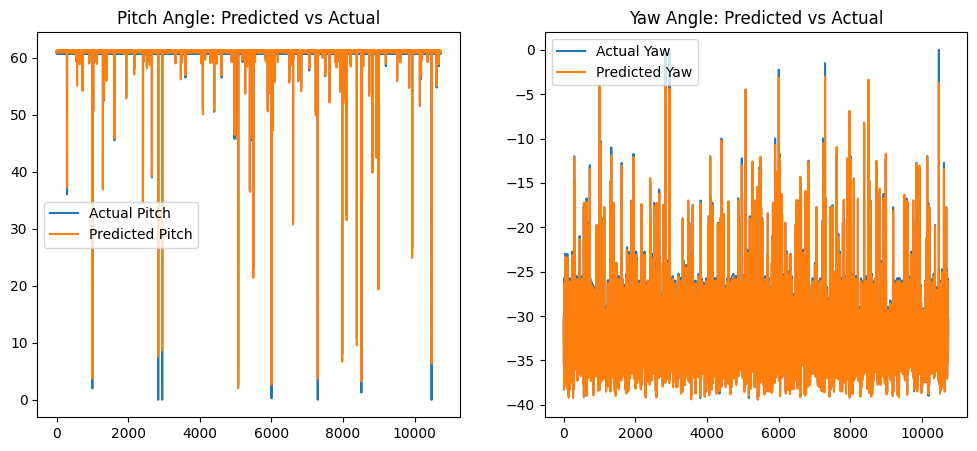

In [11]:
# Plot Predictions vs Actual
plt.figure(figsize=(12, 5))

# Pitch angle comparison
plt.subplot(1, 2, 1)
plt.plot(Y_actual[:, 0], label='Actual Pitch')
plt.plot(Y_pred[:, 0], label='Predicted Pitch')
plt.legend()
plt.title('Pitch Angle: Predicted vs Actual')

# Yaw angle comparison
plt.subplot(1, 2, 2)
plt.plot(Y_actual[:, 1], label='Actual Yaw')
plt.plot(Y_pred[:, 1], label='Predicted Yaw')
plt.legend()
plt.title('Yaw Angle: Predicted vs Actual')

plt.show()

## Save Model and Results

In [12]:
# Save trained model
model.save('NARX_helicopter_model.h5')
print("Model saved successfully.")

# Save results to Excel
narx_results = {
    "Model": "NARX",
    "MSE": mean_squared_error(Y_actual, Y_pred),
    "RMSE": np.sqrt(mean_squared_error(Y_actual, Y_pred)),
    "MAE": mean_absolute_error(Y_actual, Y_pred),
    "R²": r2_score(Y_actual, Y_pred),
    "Training Time (s)": training_time
}

df_results = pd.DataFrame([narx_results])
df_results.to_excel("model_performance.xlsx", index=False)

# Download file in Google Colab
from google.colab import files
files.download("model_performance.xlsx")

Model saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>